In [8]:
import os
import numpy as np
import scipy.stats as st
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('figure', dpi=200)
plt.rc('legend', fontsize=6)

In [14]:
# Load the results:
experiment_path = Path('experiment')
policies_memmap = np.lib.format.open_memmap(str(experiment_path / 'policies.npy'), mode='r')
performance_memmap = np.lib.format.open_memmap(str(experiment_path / 'episodic_performance.npy'), mode='r')
parameters = performance_memmap['parameters']
results = performance_memmap['performance']['results']
num_configurations, num_ace_runs, num_policies, num_evaluation_runs = results.shape

In [24]:
print(np.unique(performance_memmap['performance']['timesteps'][0]))

[    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000]


Text(0, 0.5, 'Total Reward')

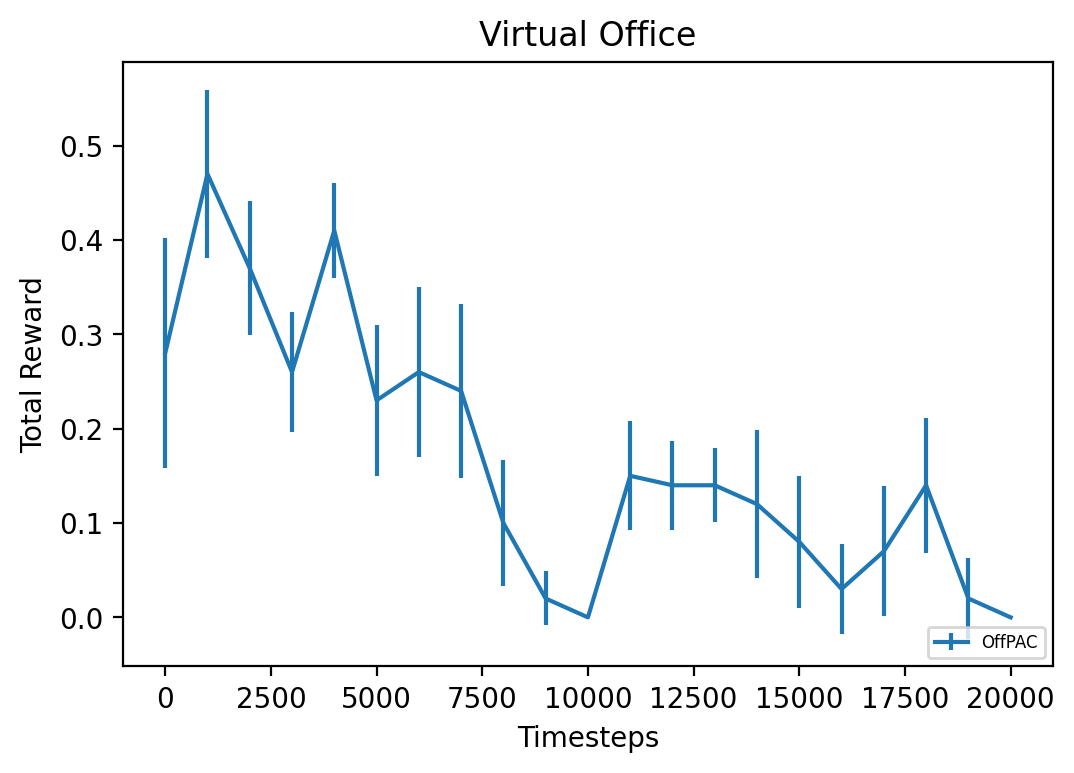

In [25]:
# Average results over evaluation runs:
mean_eval_results = np.mean(results, axis=3)
var_eval_results = np.var(results, axis=3)

# Average results over ACE runs:
mean_results = np.mean(mean_eval_results, axis=1)
# Combine estimates of SEM correctly (We're sampling polices learned by the algorithms, then sampling the performance of these sampled policies, so the standard errors must be combined appropriately (https://stats.stackexchange.com/questions/231027/combining-samples-based-off-mean-and-standard-error)):
sem_results = np.sqrt(np.sum(var_eval_results / num_evaluation_runs, axis=1)) / num_ace_runs

total_return = mean_results.mean(axis=1)

fig, ax = plt.subplots()

best_config_num = np.nanargmax(total_return)
x = np.unique(performance_memmap['performance']['timesteps'][0])
y = mean_results[best_config_num]
cis = sem_results[best_config_num] * st.t.ppf((1.0 + 0.95) / 2, num_evaluation_runs - 1)

ax.errorbar(x, y, yerr=[cis, cis], label='OffPAC')

plt.legend(loc="lower right")
plt.title('Virtual Office')
plt.xlabel('Timesteps')
plt.ylabel('Total Reward')
# plt.ylim(-5000, 0)

In [ ]:
# Average results over evaluation runs:
mean_eval_performance = np.mean(performance, axis=0)
var_eval_performance = np.var(performance, axis=0)

# Average results over ACE runs:
mean_performance = np.mean(mean_eval_performance, axis=0)
# Combine estimates of SEM correctly (We're sampling polices learned by the algorithms, then sampling the performance of these sampled policies, so the standard errors must be combined appropriately (https://stats.stackexchange.com/questions/231027/combining-samples-based-off-mean-and-standard-error)):
sem_performance = np.sqrt(np.sum(var_eval_performance / num_evaluation_runs, axis=0)) / num_ace_runs

# Get the OffPAC and ACE configurations with best total performance:
total_return = mean_performance.sum(axis=1)

# Plot the performance of the best parameters:
fig, ax = plt.subplots()

offpac_returns = total_return[configurations['eta'] == 0.]
best_offpac_config_num = np.argmax(offpac_returns)
best_offpac_config = configurations[np.argmax(offpac_returns)]
policies = list(best_offpac_config)[-1]
x = policies['timesteps']
y = mean_performance[configurations['eta'] == 0.][best_offpac_config_num]
confidence_intervals = sem_performance[configurations['eta'] == 0.][best_offpac_config_num] * st.t.ppf((1.0 + 0.95) / 2, num_evaluation_runs - 1)
ax.errorbar(x, y, yerr=[confidence_intervals, confidence_intervals], label='OffPAC')

ace_returns = total_return[configurations['eta'] == 1.]
best_ace_config_num = np.argmax(offpac_returns)
best_ace_config = configurations[np.argmax(ace_returns)]
policies = list(best_ace_config)[-1]
x = policies['timesteps']
y = mean_performance[configurations['eta'] == 1.][best_ace_config_num]
confidence_intervals = sem_performance[configurations['eta'] == 1.][best_ace_config_num] * st.t.ppf((1.0 + 0.95) / 2, num_evaluation_runs - 1)
ax.errorbar(x, y, yerr=[confidence_intervals, confidence_intervals], label='ACE')

plt.legend(loc="lower right")
plt.title('OffPAC vs ACE on Mountain Car')
plt.xlabel('Timesteps')
plt.ylabel('Total Reward')
plt.ylim(-1000, 0)
plt.savefig('offpac_vs_ace_on_mountain_car')